# Test Imperfect Lorenz Model 

In [1]:
from pathlib import Path
import sys
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import xarray as xr

# Add src folder to Python path
sys.path.append(str(Path("../src").resolve()))

from data_generation import generate_data
from lstm import WindowedTimeSeries, train_model, predict_one_step, predict_autoregressive
from ode_model import LorenzModel

In [2]:
data = generate_data(10000, noise_level=0.05)

In [3]:
model = LorenzModel()

In [4]:
preds = model.predict(y0=data)

In [5]:
time_step = 0.05
c_range = np.linspace(12,16,9)
k_range = [1,5,10,15,20]

for k in k_range:
  true = data
  true = true[k: , :]
  for c in c_range:
    model.update_params(c=c, t_step=time_step*k)
    preds = model.predict(y0=data)

    preds = preds[:-k, :]
    mse = np.mean((preds - true)**2)
    print(f"k:{k}, c:{c:.2f}, MSE:{mse}")



k:1, c:12.00, MSE:1.6989601363885134
k:1, c:12.50, MSE:1.6030021201396658
k:1, c:13.00, MSE:1.5258866517090441
k:1, c:13.50, MSE:1.463348741190627
k:1, c:14.00, MSE:1.4122008213192956
k:1, c:14.50, MSE:1.3700363905627821
k:1, c:15.00, MSE:1.3350206185811213
k:1, c:15.50, MSE:1.3057411917916988
k:1, c:16.00, MSE:1.2811011123214715
k:5, c:12.00, MSE:11.279692555830973
k:5, c:12.50, MSE:8.14002771152354
k:5, c:13.00, MSE:6.380173284099273
k:5, c:13.50, MSE:5.279667476800921
k:5, c:14.00, MSE:4.537801495295585
k:5, c:14.50, MSE:4.011417076367801
k:5, c:15.00, MSE:3.623871073866561
k:5, c:15.50, MSE:3.330422023798892
k:5, c:16.00, MSE:3.103226308755876
k:10, c:12.00, MSE:39.19700089066981
k:10, c:12.50, MSE:27.361223681805082
k:10, c:13.00, MSE:23.597857231845737
k:10, c:13.50, MSE:22.06627321948671
k:10, c:14.00, MSE:21.129047161318738
k:10, c:14.50, MSE:20.50329306429173
k:10, c:15.00, MSE:20.063104247649342
k:10, c:15.50, MSE:19.742077537587114
k:10, c:16.00, MSE:19.50159552556723
k:15, 

# Physical model never quite gets as good as LSTM with such noisy input data

In [6]:
assimilated_data = generate_data(10000, noise_level=0.01)

In [20]:
time_step = 0.05
c_range = np.arange(15,101)
k_range = [5,10]
MSE = np.zeros((len(k_range), len(c_range)))

for i_k, k in enumerate(k_range):
  true = data
  true = true[k: , :]
  for i_c, c in enumerate(c_range):
    model.update_params(c=c, t_step=k*time_step)
    # CHANGE INPUT DATA TO ASSIMILATED DATA
    preds = model.predict(y0=assimilated_data)
    preds = preds[:-k, :]
    mse = np.mean((preds - true)**2)
    MSE[i_k, i_c] = mse
    print(f"k:{k}, c:{c:.2f}, MSE:{mse}")


k:5, c:15.00, MSE:2.3655396587354214
k:5, c:16.00, MSE:1.839572943156543
k:5, c:17.00, MSE:1.5123003876814667
k:5, c:18.00, MSE:1.2966358653719143
k:5, c:19.00, MSE:1.1482865487860359
k:5, c:20.00, MSE:1.0427474165234976
k:5, c:21.00, MSE:0.9655850963091788
k:5, c:22.00, MSE:0.9078726715987464
k:5, c:23.00, MSE:0.8638667628853701
k:5, c:24.00, MSE:0.8297494930757326
k:5, c:25.00, MSE:0.8029119297977495
k:5, c:26.00, MSE:0.7815285251102213
k:5, c:27.00, MSE:0.7642952913531139
k:5, c:28.00, MSE:0.7502637566885242
k:5, c:29.00, MSE:0.7387328498165292
k:5, c:30.00, MSE:0.7291768535391334
k:5, c:31.00, MSE:0.7211963969708911
k:5, c:32.00, MSE:0.7144845007497516
k:5, c:33.00, MSE:0.708802658970529
k:5, c:34.00, MSE:0.7039637364801761
k:5, c:35.00, MSE:0.6998195712834208
k:5, c:36.00, MSE:0.6962518745290804
k:5, c:37.00, MSE:0.6931654737119491
k:5, c:38.00, MSE:0.6904832421845601
k:5, c:39.00, MSE:0.6881422565230398
k:5, c:40.00, MSE:0.686090857679164
k:5, c:41.00, MSE:0.6842863841201213
k:5,

In [21]:
ds = xr.Dataset(
  data_vars=dict(
    mse=(["k","c"], MSE),
  ),
  coords=dict(
    k=k_range,
    c=c_range,
  ),
  attrs=dict(
    time_step=time_step,
    description="MSE of physical model predictions",
  )
)

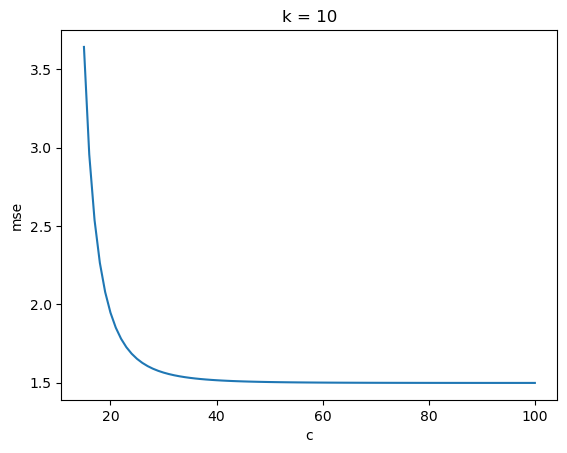

In [23]:
ds.mse.sel(k=10).plot()

In [34]:
out_path = Path("../data/processed/mse_physical_model.nc")

ds.to_netcdf(out_path)